<a href="https://colab.research.google.com/github/Salmia98/MITS-001-Machine-Learning-Projects/blob/main/Image_Classification_Demo_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import tensorflow as tf
import lz4
import os
import cv2
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from numpy import asarray
from PIL import Image
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from mtcnn.mtcnn import MTCNN # if you encounter the error 'No module named mtcnn', execute the following command !pip install mtcnn
from google.colab import drive

In [21]:
# Set parameters
IMAGE_SIZE = (128, 128)  # Resize images to 128x128
BATCH_SIZE = 32
EPOCHS = 10
# DATA_DIR = "drive/MyDrive/PERSONAL/LECTURES/MACHINE LEARNING/IMAGE CLASSIFICATION/data/image_classification_dataset"  # Update with the path to your dataset§
# DATA_DIR = "/Users/ericjohnemberda/Pictures/image_classification_dataset"
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/MITS 001 - Machine Learning/image_classification_dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# draw an image with detected objects
def draw_image_with_boxes(filename, result_list):
  # load the image
  data = pyplot.imread(filename)
  # plot the image
  pyplot.imshow(data)
  # get the context for drawing boxes
  ax = pyplot.gca()
  # plot each box
  for result in result_list:
    # get coordinates
    x, y, width, height = result['box']
    # create the shape
    rect = Rectangle((x, y), width, height, fill=False, color='red')
    # draw the box
    ax.add_patch(rect)

  # draw the dots (for eyes, nose, and mouth)
  for key, value in result['keypoints'].items():
    # create and draw dot
    dot = Circle(value, radius=2, color='red')
    ax.add_patch(dot)

In [23]:
# Source: https://www.sitepoint.com/keras-face-detection-recognition/
def extract_face_from_image(image_path, required_size=(128, 128)):
  # load image and detect faces
  image = pyplot.imread(image_path)
  detector = MTCNN()
  faces = detector.detect_faces(image)

  face_images = []

  for face in faces:
    # extract the bounding box from the requested face
    x1, y1, width, height = face['box']
    x2, y2 = x1 + width, y1 + height

    # extract the face
    face_boundary = image[y1:y2, x1:x2]

    # resize pixels to the model size
    face_image = Image.fromarray(face_boundary)
    face_image = face_image.resize(required_size)
    face_array = asarray(face_image)
    face_images.append(face_array)

  return face_images

In [24]:
# Load and preprocess data
def load_data(data_dir):
    image_data = []
    labels = []
    class_names = os.listdir(data_dir)

    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)



            # img = tf.keras.utils.load_img(img_path, target_size=IMAGE_SIZE)

            # load image from file
            pixels = pyplot.imread(img_path)
            # create the detector, using default weights
            detector = MTCNN()
            # detect faces in the image
            faces = detector.detect_faces(pixels)
            # display faces on the original image
            draw_image_with_boxes(img_path, faces)
            extracted_face = extract_face_from_image(img_path)

            img_array = tf.keras.utils.img_to_array(cv2.resize(extracted_face[0],(128,128))) #get the first image. previously just img
            image_data.append(img_array)
            labels.append(idx)

    image_data = tf.convert_to_tensor(image_data) / 255.0  # Normalize images

    labels = tf.convert_to_tensor(labels)
    return image_data, labels, class_names


Loading data...
Classes: ['tom', 'robert', 'salmia']


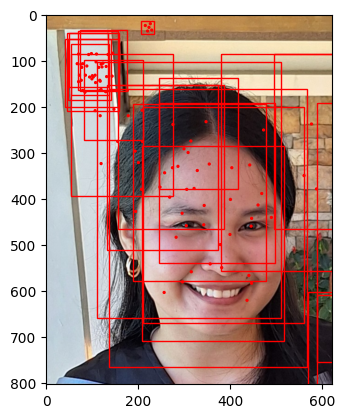

In [25]:
print("Loading data...")
image_data, labels, class_names = load_data(DATA_DIR)
print(f"Classes: {class_names}")

# if you encounter the error, LZ4 is not installed. Install it with pip: https://python-lz4.readthedocs.io/, !pip install LZ4

In [26]:
labels

<tf.Tensor: shape=(25,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2], dtype=int32)>

In [27]:
image_data[0]

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.07450981, 0.07843138, 0.05882353],
        [0.07058824, 0.07450981, 0.05490196],
        [0.07058824, 0.07450981, 0.05490196],
        ...,
        [0.08235294, 0.08627451, 0.06666667],
        [0.07450981, 0.07843138, 0.05882353],
        [0.06666667, 0.07450981, 0.05490196]],

       [[0.0627451 , 0.05882353, 0.04313726],
        [0.0627451 , 0.0627451 , 0.04705882],
        [0.0627451 , 0.06666667, 0.04705882],
        ...,
        [0.09019608, 0.09411765, 0.07450981],
        [0.08235294, 0.08627451, 0.06666667],
        [0.07058824, 0.07843138, 0.05882353]],

       [[0.05490196, 0.05098039, 0.03529412],
        [0.05098039, 0.05490196, 0.03529412],
        [0.05098039, 0.05490196, 0.03529412],
        ...,
        [0.07843138, 0.08235294, 0.0627451 ],
        [0.07058824, 0.07450981, 0.05490196],
        [0.0627451 , 0.07058824, 0.05098039]],

       ...,

       [[0.13725491, 0.12156863, 0.09411765],
        [0.12

In [28]:
# Split into train and validation sets
# Convert TensorFlow tensors to NumPy arrays before using train_test_split
image_data_np = image_data.numpy()
labels_np = labels.numpy()

In [29]:
# Split into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(image_data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(image_data_np, labels_np, test_size=0.2, random_state=42)



In [30]:
# Define the CNN model
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(class_names), activation='softmax')
    ])
    return model

In [31]:

model = create_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [32]:
# Train the model
BATCH_SIZE = 10
EPOCHS = 20
print("Training the model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

Training the model...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 907ms/step - accuracy: 0.2667 - loss: 1.8641 - val_accuracy: 0.6000 - val_loss: 1.0650
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 394ms/step - accuracy: 0.3333 - loss: 1.3126 - val_accuracy: 0.4000 - val_loss: 1.1018
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step - accuracy: 0.4000 - loss: 1.0879 - val_accuracy: 0.4000 - val_loss: 1.0587
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step - accuracy: 0.4000 - loss: 1.0595 - val_accuracy: 0.4000 - val_loss: 1.0411
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step - accuracy: 0.5000 - loss: 1.0097 - val_accuracy: 0.4000 - val_loss: 1.0467
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step - accuracy: 0.4667 - loss: 1.0110 - val_accuracy: 0.4000 - val_loss: 1.0183
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step - accuracy: 0.5667 - loss: 0.9524 - val_accuracy: 0.4000 - val_loss: 1.0104
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step - accuracy: 0.6333 - loss: 0.9064 - val_accura

In [33]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4000 - loss: 1.7995
Validation Accuracy: 0.40


In [34]:

# Save the model
model.save("person_classifier_model.h5")
print("Model saved as person_classifier_model.h5")

Model saved as person_classifier_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Predicted class: tom


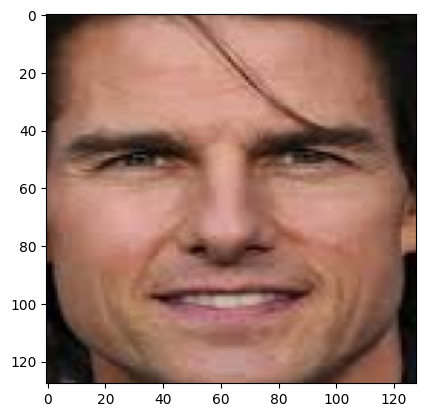

In [35]:
 # Add a batch dimension to use it with the model
pyplot.imshow(image_data_np[0])
image_array = np.expand_dims(image_data_np[0], axis=0)
prediction = model.predict(image_array)
print("Predicted class:", class_names[np.argmax(prediction)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted class: tom


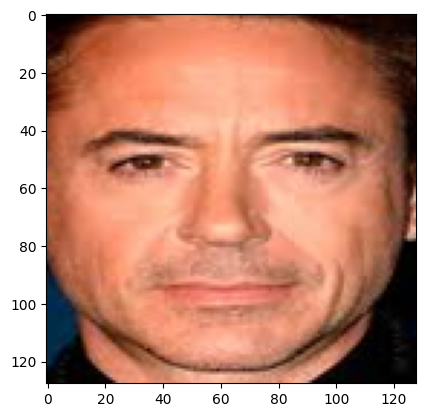

In [36]:
 # Add a batch dimension to use it with the model
pyplot.imshow(image_data_np[11])
image_array = np.expand_dims(image_data_np[11], axis=0)
prediction = model.predict(image_array)
print("Predicted class:", class_names[np.argmax(prediction)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted class: tom


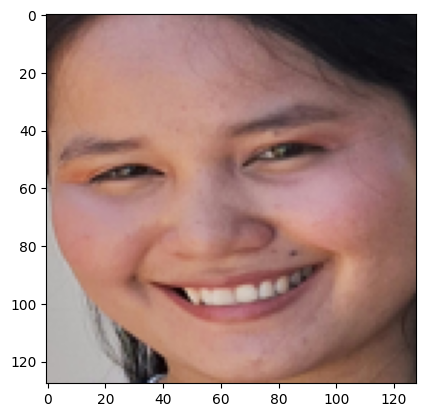

In [37]:
 # Add a batch dimension to use it with the model
pyplot.imshow(image_data_np[22])
image_array = np.expand_dims(image_data_np[22], axis=0)
prediction = model.predict(image_array)
print("Predicted class:", class_names[np.argmax(prediction)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted class: robert
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted class: robert
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted class: robert
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted class: robert
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted class: robert
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
P

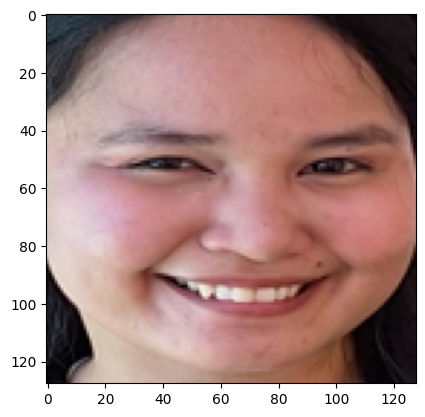

In [38]:
for i in image_data_np:
    pyplot.imshow(i)
    image_array = np.expand_dims(i, axis=0)
    prediction = model.predict(image_array)
    print("Predicted class:", class_names[np.argmax(prediction)])